# Tugas Klasifikasi dan Prediksi
**Data Mining and Data Warehouse**

### Kelompok 3
- Ayesha Ali Firdaus (2101990)
- Ibnu Adeng Kurnia (2101769)
- Ihsan Ghozi Zulfikar (2103303)
- M. Fadhillah Nursyawal (2107135)
- M. Labib Husain (2101989)

In [1]:
# Import library
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import pickle
import xgboost as xgb
import joblib

# Import Data Training
df = pd.read_csv("C:\\Users\\AYESHA ALI FIRDAUS\\DatMin\\orders_train.csv")

### ===================PRAPROSES===================

In [2]:
# Dibuat null karena tanggal lahir tidak bisa di tebak
df.loc[df.dateOfBirth == "?", "dateOfBirth"] = np.nan
df.loc[(df.dateOfBirth == "1655-04-19", "dateOfBirth")] = np.nan

# Ingin mengubah deliveryDate yang anomali menjadi median dari waktu antar dikurangin waktu delivery yang tidak anomali
df.loc[df.deliveryDate == "?", "deliveryDate"] = np.nan #-------------- Menjadikan NULL terlebih dahulu data yang "?"
df.loc[df.deliveryDate < "2012", "deliveryDate"] = np.nan #------------ Mengubah menjadi NULL data yang kurang dari 2012
df['orderDate'] = pd.to_datetime(df['orderDate']) #-------------------- Ubah tipe data menjadi date agar bisa menghitung hari
df['deliveryDate'] = pd.to_datetime(df['deliveryDate']) #-------------- Ubah tipe data menjadi date agar bisa menghitung hari
df['handling_time'] = df['deliveryDate'] - df['orderDate'] #----------- Menambahkan atribut total hari pengantaran dari data yang tidak anomali {di dapat dari mengurangi tanggal pengiriman dengan tanggal order}
df.loc[df.handling_time < "0 days", "handling_time"] = np.nan #-------- Menjadikan NULL data yang anomali akibat deliveryDate yang anomali {contoh: 1990}
df['handling_time'].fillna(df['handling_time'].median(),inplace=True) # Mengisikan handling time yang NULL dengan median
df['deliveryDate'] = df['orderDate'] + df['handling_time'] #----------- Semua delivery date yang "?" dan kurang dari 2012 ditambahin median dari handling_time

# Menambahkan atribut age ke dalam dataset
df['dateOfBirth'] = pd.to_datetime(df['dateOfBirth']) #------------------- Mengubah tipe data dateOfBirth menjadi date
df['age'] = datetime.datetime(2013, 12, 31, 0, 0, 0) - df['dateOfBirth'] # Menghitung umur dari tahun 2013 akhir dikurangi dengan tanggal lahir
df['age'] = df['age'].dt.days #------------------------------------------- Mengubah tipe data date menjadi float64
df["age"] = df["age"].astype("Int64") #----------------------------------- Mengubah tipe data float64 menjadi int64
df["age"] = df["age"]  / 365 #-------------------------------------------- Mengubah hari menjadi tahun dengan dibagi oleh 365 hari
df["age"] = df["age"].astype("Int64") #----------------------------------- Mengubah tipe data float64 menjadi int64 {akibat dari hasil pembagian sebelumnya}
df['age'].fillna(df['age'].median(),inplace=True) #----------------------- Mengisikan age yang NULL dengan median dari age

# Mengubah tipe data salutation menjadi category
df["salutation"] = df["salutation"].astype("category")

# Drop atribut yang memiliki null dan anomali
df = df.drop(df.index[df.dateOfBirth.isnull()])
df = df.drop(df.index[df.age >100])
df = df.drop(df.index[df.age <10])
df = df.drop(df.index[(df['color']=="?") & (df['price'] == 0) & (df['size'] == "unsized")])

# Mengubah handling time menjadi int
df['handling_time'] = df['handling_time'].dt.days #-------- Mengubah tipe data yang awalnya date menjadi float64 karena diambil harinya saja
df["handling_time"] = df["handling_time"].astype("Int64") # mengubah tipe data menjadi int64

### ============Exploratory Data Analysis (EDA)==============

##### Daftar isi:
- Barang yang paling laris
- Barang yang sering di kembalikan
- Mencari kota dengan transaksi barang dengan harga yang mahal dan murah
- Boxplot usia pembeli
- Barang yang dikembalikan dengan time delivery dan price
- Barang yang dikembalikan dengan umur
- Barang yang laku terjual perbulan & pertahun
- Jumlah pembeli perbulan & pertahun
- Persebaran umur tiap daerah
- Harga dengan Pengembalian
- Chart jumlah umur

<AxesSubplot:xlabel='itemID', ylabel='count'>

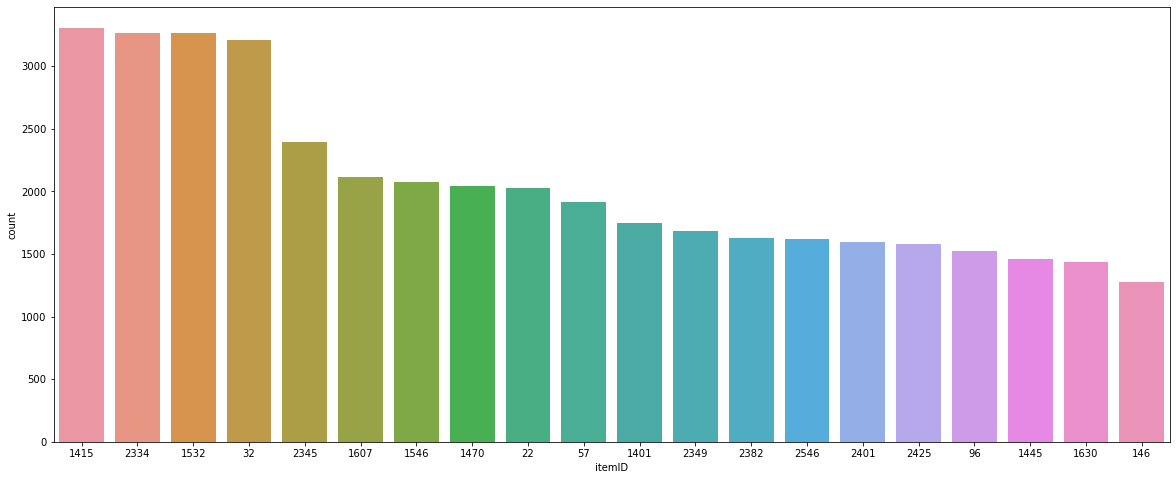

In [3]:
# Barang yang paling laris
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(ax=ax, x="itemID", data=df, order=df.itemID.value_counts().iloc[:20].index)

# Untuk mengetahui barang yang palig laris berdasarkan tiap itemID

<AxesSubplot:xlabel='itemID', ylabel='count'>

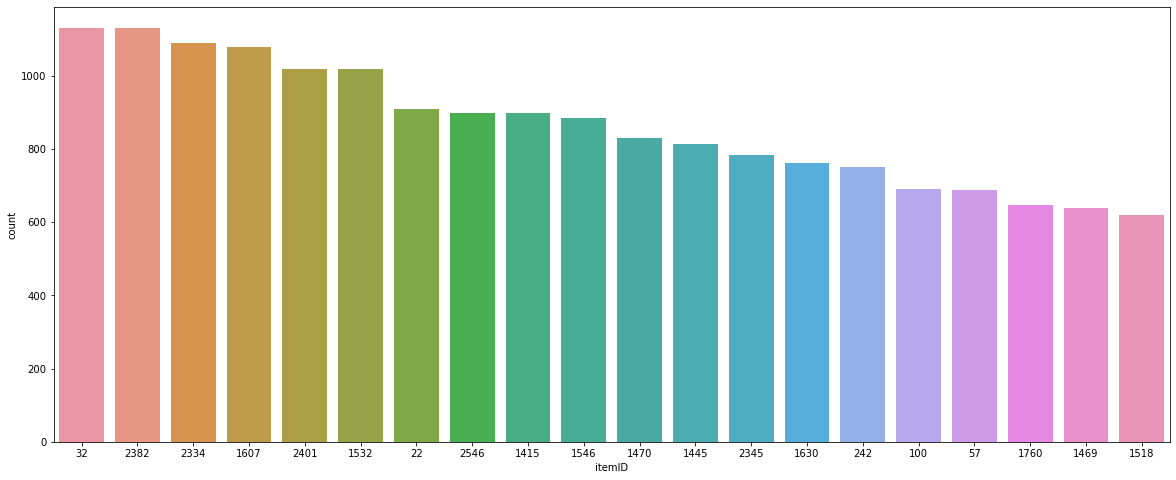

In [4]:
# Barang yang sering di kembalikan
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(ax=ax, x="itemID", data=df[df.returnShipment==1],order=df[df.returnShipment==1].itemID.value_counts().iloc[:20].index)

# Untuk mengetahui barang dengan itemID mana yang banyak di kembalikan

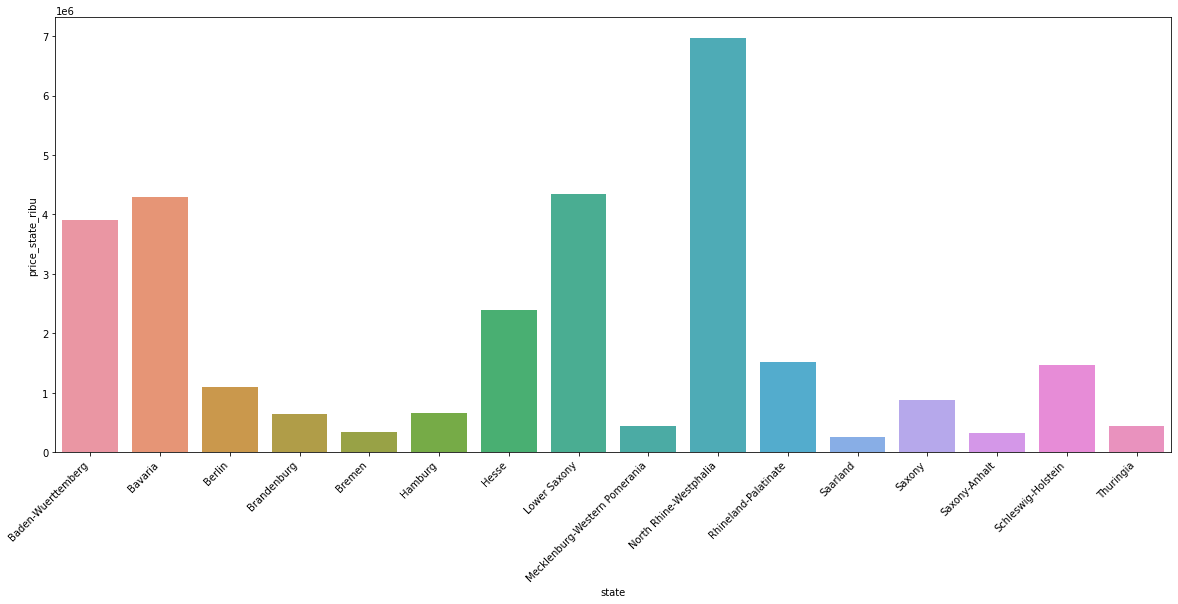

In [5]:
# Mencari kota dengan transaksi barang dengan harga yang mahal dan murah
df_temp = df.groupby(["state"])["price"].sum().rename('price_state_ribu').reset_index()
fig, ax = plt.subplots(figsize=(20, 8)) #atur ukuran chart
sns.barplot(ax=ax, x="state", y="price_state_ribu", data=df_temp)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

# Untuk mengetahui kota yang memiliki tingkat ekonomi yang tinggi

<AxesSubplot:xlabel='age'>

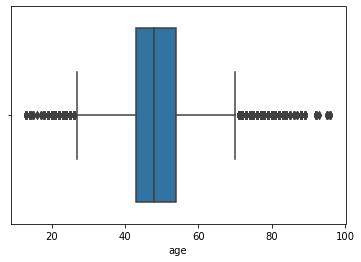

In [6]:
# Boxplot usia pembeli
sns.boxplot(x="age",data=df)

# Untuk mengetahui persebaran usia pembeli

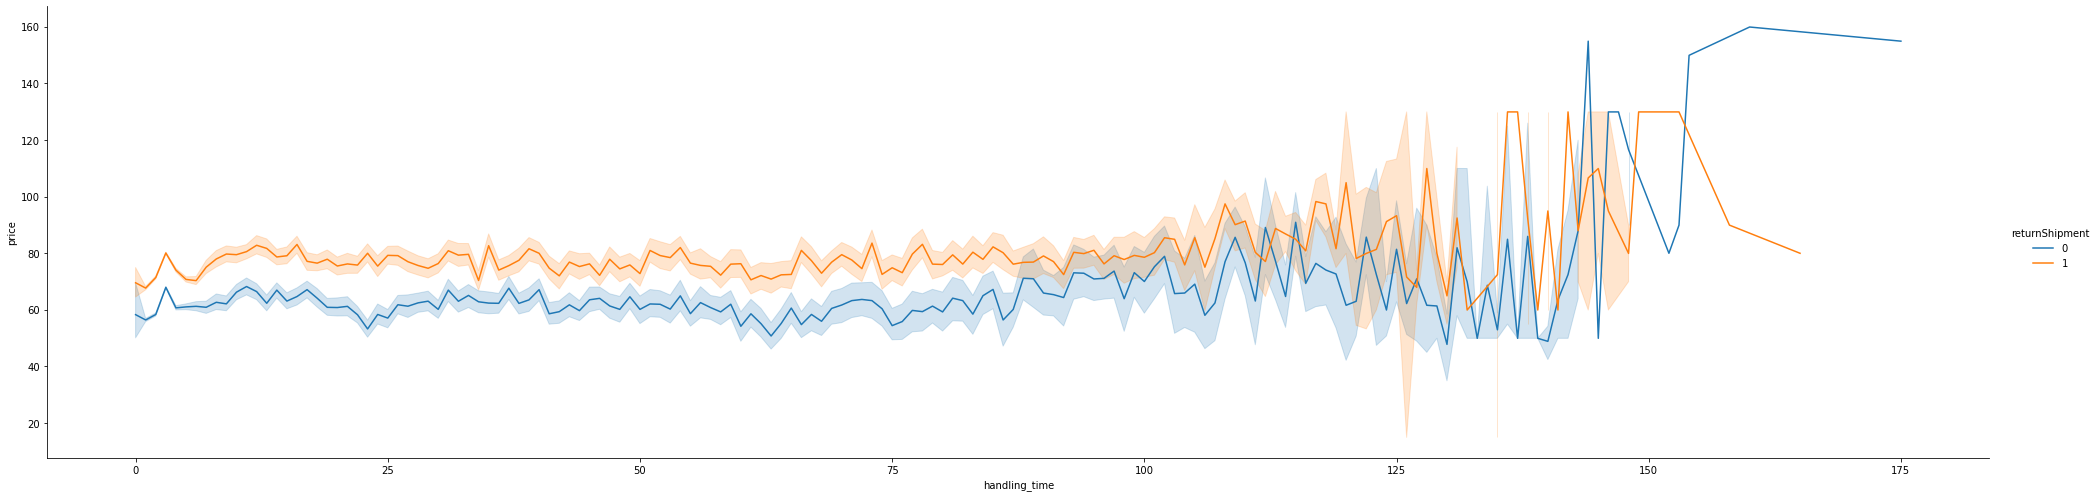

In [7]:
# Barang yang dikembalikan dengan time delivery dan price
sns.relplot(
    data=df,
    x="handling_time", y="price",
    hue="returnShipment",
    kind="line", size_order=["T1", "T2"],
    height=7, aspect=4, facet_kws=dict(sharex=False),# %% [markdown]
)

# Untuk mengetahui pengearuh antara harga dan waktu penaganan terhadap pengembalian barang

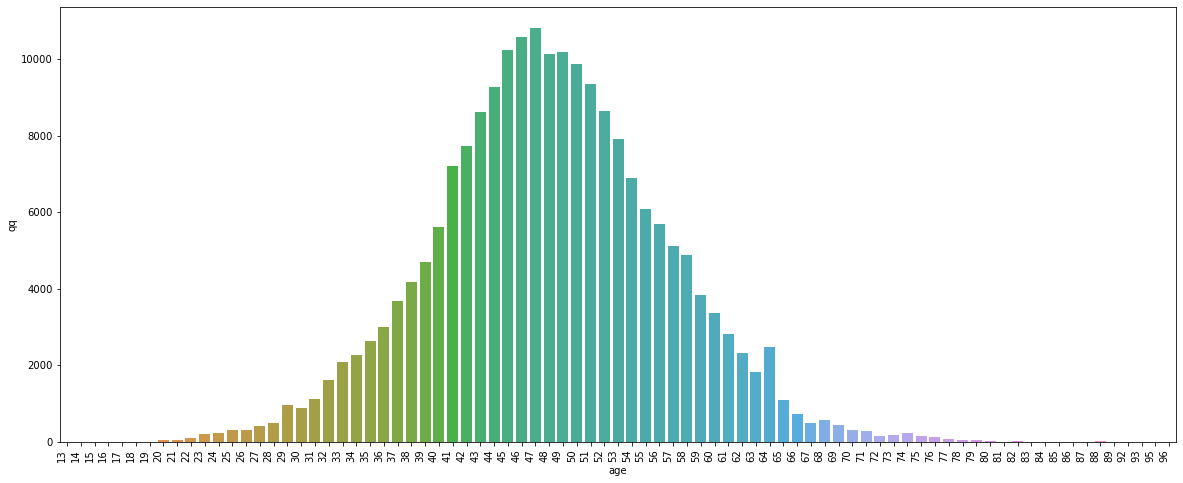

In [8]:
# Barang yang dikembalikan dengan umur
df_temp = df.groupby(["age"])["returnShipment"].sum().rename('qq').reset_index()
fig, ax = plt.subplots(figsize=(20, 8)) #atur ukuran chart
sns.barplot(ax=ax, x="age", y="qq", data=df_temp)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

# Untuk mengetahui persebaran usia yang paling banyak mengembalikan barang

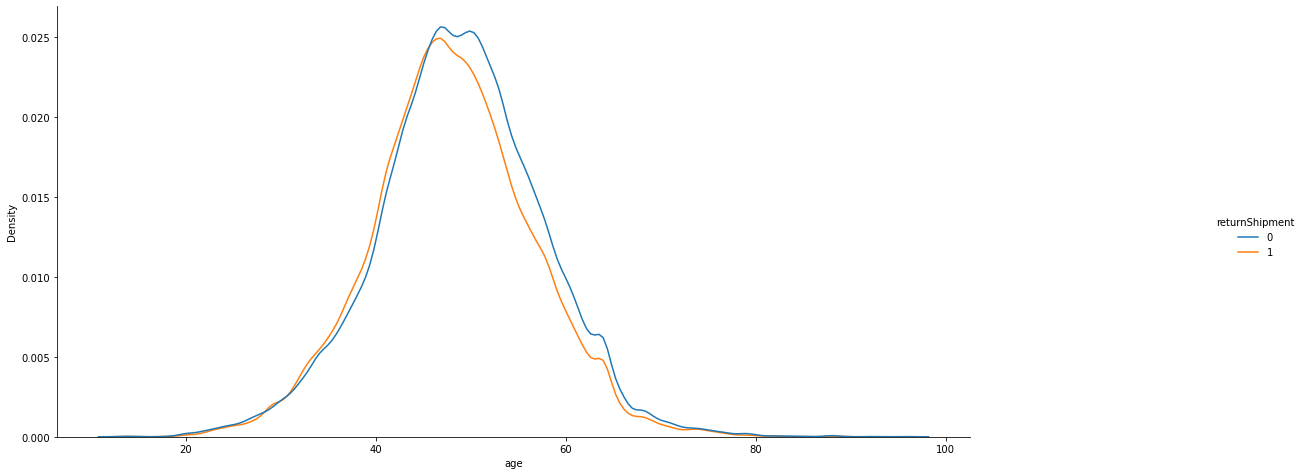

In [9]:
# Barang yang dikembalikan dengan umur
c = sns.displot(df, x="age", hue="returnShipment", kind="kde")
c.fig.set_size_inches(20,7)

# Untuk mengetahui perbandingan antara barang yang di kembalikan dengan yang tidak dari setiap umur

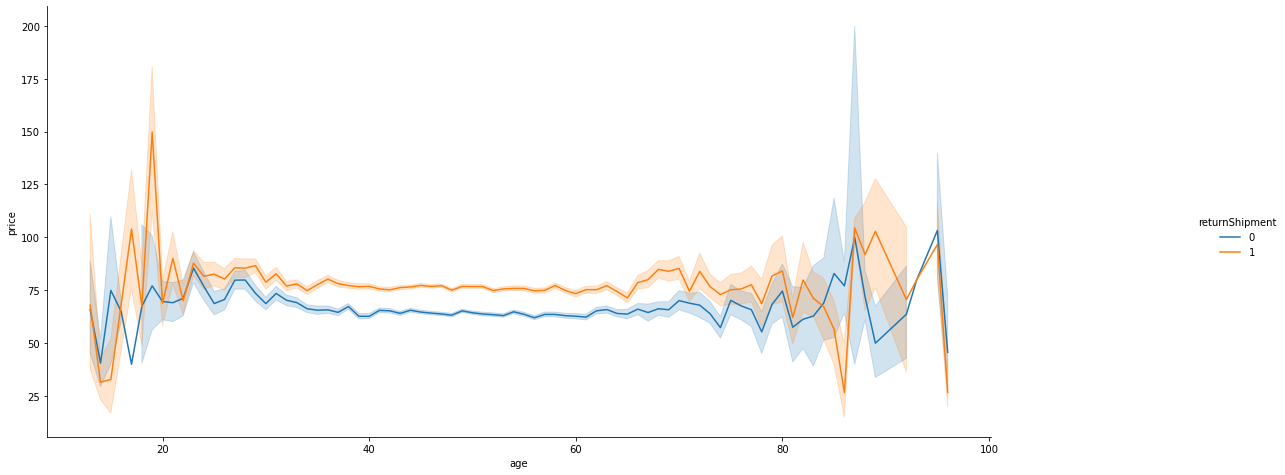

In [10]:
# Chart jumlah yang di kembalikan berdasarkan umur dan harga
c = sns.relplot(data=df, kind="line", x="age", y="price", hue="returnShipment")
c.fig.set_size_inches(20,7)

# Untuk mengetahui jumlah barang yang di kembalikan dan tidak jika dilihat berdasarkan harga barang

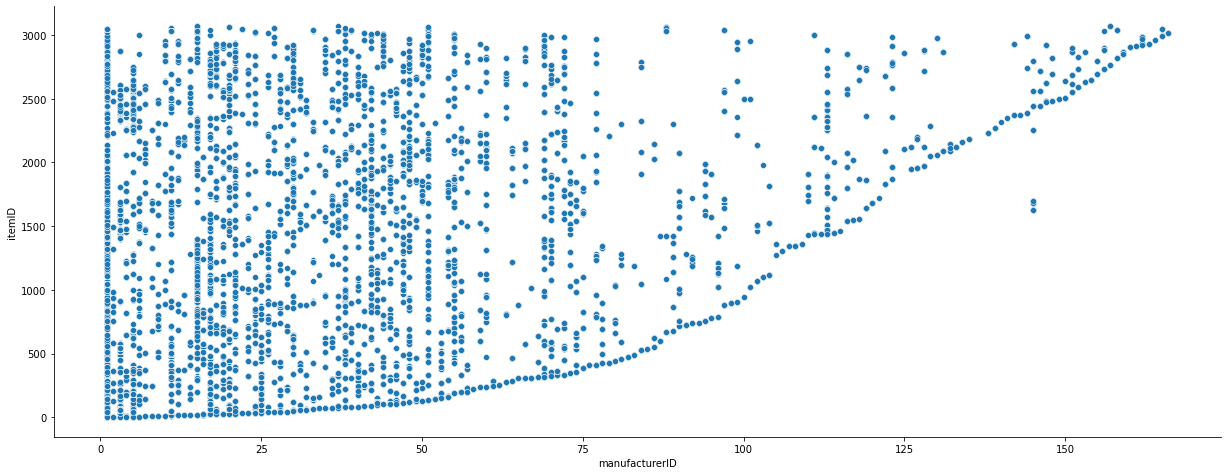

In [11]:
# Jumlah barang yang diproduksi oleh manufaktur
c = sns.relplot(data=df, x="manufacturerID", y="itemID",)
c.fig.set_size_inches(20,7)

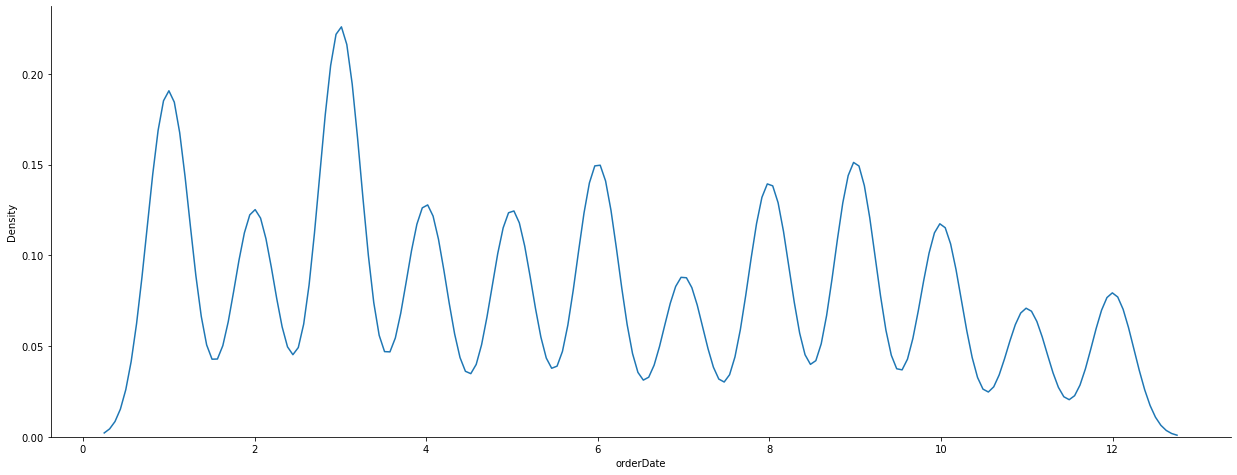

In [12]:
# Jumlah orderan perbulan
c = sns.displot(df, x=df['orderDate'].dt.month, kind="kde")
c.fig.set_size_inches(20,7)

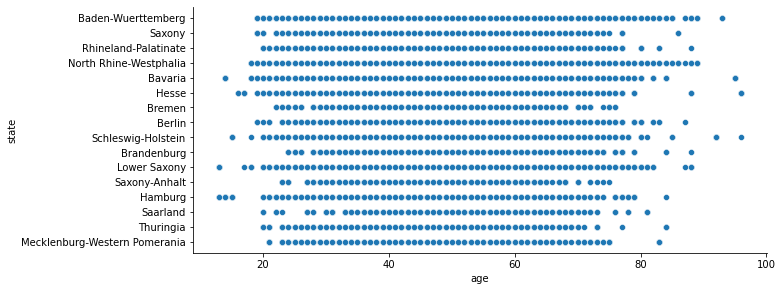

In [13]:
# Persebaran umur tiap daerah
c = sns.relplot(data = df, x="age", y="state")
c.fig.set_size_inches(20,4)

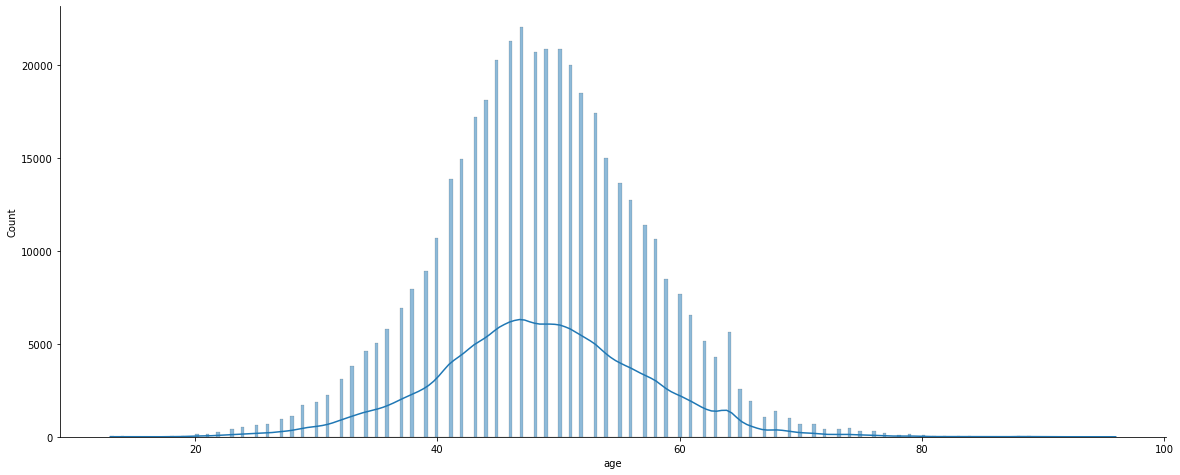

In [14]:
# Chart jumlah umur
c = sns.displot(df, x="age", kde=True)
c.fig.set_size_inches(20,7)

# Untuk mengetahui jumlah individu setiap umur

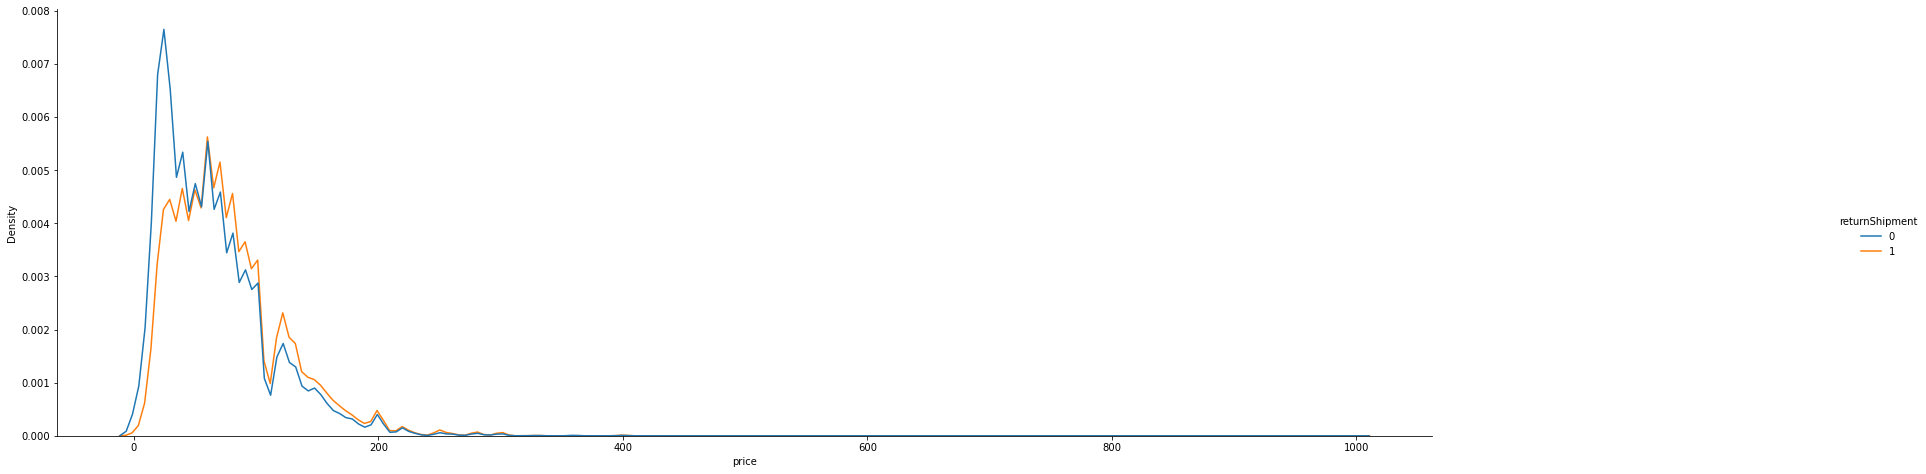

In [15]:
# Harga dengan Pengembalian
c = sns.displot(df, x="price", hue="returnShipment", kind="kde")
c.fig.set_size_inches(30,7)

# Untuk mengetahui apakah harga mempengaruhi pengembalian barang

## =============Klasifikasi==================

In [16]:
# Pembuangan atribut yang tidak terpakai (orderItemId, dateOfBirth, Creation date, deliveryDate, orderDate)
df_temp = df
df_temp = df_temp.drop(['orderItemID', 'dateOfBirth','creationDate', 'orderDate', 'deliveryDate', 'handling_time'],axis=1)

In [17]:
# Membuat One-Hot Encoding
df_temp = pd.get_dummies(data=df_temp, columns = ['state', 'color', 'size', 'salutation'])

In [18]:
# Menentukan Kelas Target
le = preprocessing.LabelEncoder()
le.fit(df_temp.returnShipment)
Y = le.transform(df_temp.returnShipment)
X = df_temp.drop("returnShipment",axis=1)

In [19]:
# Memisahkan antara data train dengan data test
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

with open("C:\\Users\\AYESHA ALI FIRDAUS\\DatMin\\orders_class.pickle", 'wb') as fp:
    pickle.dump(X_train.columns, fp)


# Menjalankan XGBoost
clf = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = "mlogloss", 
                        max_depth = 30, gamma=0.1, subsample = 0.9,learning_rate=0.1, 
                        n_estimators = 50, nthread=4)

clf.fit(X_train, Y_train)# PCA
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)

# Mencetak hasil dari XGBoost
print("Akurasi {}".format(acc))
print(classification_report(Y_test, Y_pred))

# Untuk mengethaui atribut yang berperan dalam melakukan prediksi
feature_importances = pd.DataFrame(clf.feature_importances_,index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)

print(feature_importances)

# Mencetak Confusion Matriks
print(confusion_matrix(Y_test, Y_pred))

# Mengeksport hasil model
joblib.dump(clf, "C:\\Users\\AYESHA ALI FIRDAUS\\DatMin\\xgboost_order_class.joblib")